# Parallel Wrapper Evaluation

## Environment

### Imports

In [1]:
import sys
sys.path.append('/home/vincenzoscotti/Projects/transformer_wrappers/src')

In [2]:
import os
import itertools
from datetime import datetime
import json
import pandas as pd
import hashlib

In [3]:
import torch

In [4]:
from transformer_wrappers.wrappers import ResizableCausalLMWrapper

/home/vincenzoscotti/anaconda3/envs/trwrap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import lm_eval

In [6]:
from typing import List, Dict

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants and globals

In [8]:
TOKEN = None  # HF Token

In [9]:
EXPERIMENTS_DIR_PATH: str = '/home/vincenzoscotti/Projects/transformer_wrappers/experiments'
EXPERIMENT_SERIES_ID: str = 'resizable_wrapper'

In [10]:
BENCHMARKS: List[str] = ['hellaswag', 'winogrande', 'truthfulqa_mc1', 'gsm8k', 'arc_challenge', 'mmlu']

In [11]:
BATCH_SIZE: int = 8

In [12]:
MODEL = 'mistralai/Mistral-7B-Instruct-v0.2'  
# MODEL = 'meta-llama/Llama-2-7b-hf'
# MODEL = 'google/gemma-7b'
MODEL_CONFIGS = {
    'torch_dtype': torch.bfloat16,
    'device_map': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'token': TOKEN
    # 'load_in_4bit': True, 
    # 'bnb_4bit_use_double_quant': True, 
    # 'bnb_4bit_quant_type': 'nf4', 
    # 'bnb_4bit_compute_dtype': torch.bfloat16
}
TOKENIZER = MODEL
TOKENIZER_CONFIGS = {'token': TOKEN}
WRAPPER_CONFIGS_KEYS: List[str] = ['max_token_len']
WRAPPER_CONFIGS_VALUES: List[str] = [[1, 2, 3, 4, None]]

In [ ]:
if not os.path.exists(EXPERIMENTS_DIR_PATH):
    os.mkdir(EXPERIMENTS_DIR_PATH)
if not os.path.exists(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID)):
    os.mkdir(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID))

current_experiments_dir = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, MODEL.replace('/', '-'))
if not os.path.exists(current_experiments_dir):
    os.mkdir(current_experiments_dir)

### Helper functions

In [ ]:
def get_configs_hash(configs):
    return hashlib.hashlib.sha256(str(configs).encode()).hexdigest()

In [ ]:
def append_results(**kwargs):
    file_path = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, 'results.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index=None)
        df = pd.concat([df, pd.DataFrame.from_dict([kwargs])], ignore_index=True)
    else:
        df = pd.DataFrame.from_dict([kwargs])
    df.to_csv(file_path, index=False)

In [ ]:
def load_results_df():
    file_path = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, 'results.csv')
    return df = pd.read_csv(file_path, index=None)

In [13]:
def save_results(results, config, benchmark):
    # Create dir (if necessary)
    dir_path = os.path.join(current_experiments_dir, get_get_configs_hash(configs))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # Save configs (if necessary)
    config_file_path = os.path.join(dir_path, 'configs.yml')
    if not os.path.exists(config_file_path):
        with open(config_file_path, 'w') as f:
            yaml.dump(configs, f)
    # Save results
    file_path = os.path.join(dir_path, f'{benchmark}.json')
    with open(file_path, 'w') as f:
        json.dump({k: results[k] for k in results if k!='config'}, f)
    # Append results to main CSV
    append_results(model=MODEL, benchmark=benchmark, **results[benchmark], **configs)

In [15]:
def check_res_exists(config, benchmark):
    dir_path = os.path.join(current_experiments_dir, get_get_configs_hash(configs))
    file_path = os.path.join(dir_path, f'{benchmark}.json')
    
    return os.path.exists(file_path)

## Experiment:

### Model

Load model

In [17]:
model = ResizableCausalLMWrapper.from_pretrained(
    MODEL, 
    model_kwargs=MODEL_CONFIGS,
    tokenizer_kwargs=TOKENIZER_CONFIGS
)
model.enable_benchmarking()

Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


### Evaluation

In [18]:
experiment_configs: List[Dict] = [
    {k: v for k, v in zip(WRAPPER_CONFIGS_KEYS, configs)}
    for configs in itertools.product(*WRAPPER_CONFIGS_VALUES)
]

In [ ]:
# Iterate over benchmarks
for benchmark in benchmarks:
    # Iterate over configs
    for config in experiment_configs:
        # Run evaluation (if results are not avaialble yet)
        if not check_results_exists(config, benchmark):
            # Set attribute values  # TODO fixme
            for k, v in config.items():
                setattr(model.transformer_wrapper, k, v)
            # Run evaluation
            results = lm_eval.simple_evaluate(
                model="hf",
                model_args={'pretrained': model, 'tokenizer': model.tokenizer, 'backend': 'causal'},
                # model_args='pretrained=mistralai/Mistral-7B-Instruct-v0.2,attn_implementation=eager,device_map=cuda',
                tasks=BENCHMARKS,
                batch_size=BATCH_SIZE,
                # log_samples=True,
            )
            # Save results
            save_results(results, config, benchmark)

2024-03-27:11:57:56,718 INFO     [evaluator.py:129] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-03-27:11:57:56,718 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-27:11:57:56,721 INFO     [huggingface.py:414] Overrode HF model backend type, and using type 'causal'
2024-03-27:11:57:56,724 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-03-27:11:57:58,063 INFO     [evaluator.py:190] get_task_dict has been updated to accept an optional argument, `task_manager`Read more here:https://github.com/EleutherAI/lm-evaluation-harness/blob/main/docs/interface.md#external-library-usage
2024-03-27:11:58:02,370 INFO     [task.py:395] Building contexts fo

### Results

Gather experiments results

In [27]:
results_df = load_results_df()
results_df

,benchmark,score,model,p_rate,block_parallel,iterative,average,compensate_avg
0,hellaswag,0.774248,mistralai/Mistral-7B-Instruct-v0.2,2,False,True,False,False
1,hellaswag,0.261103,mistralai/Mistral-7B-Instruct-v0.2,4,True,False,False,False
2,hellaswag,0.523302,mistralai/Mistral-7B-Instruct-v0.2,4,True,True,True,False
3,hellaswag,0.445330,mistralai/Mistral-7B-Instruct-v0.2,4,True,True,False,False
4,hellaswag,0.746764,mistralai/Mistral-7B-Instruct-v0.2,2,True,True,True,True
5,hellaswag,0.263195,mistralai/Mistral-7B-Instruct-v0.2,2,True,False,True,True
6,hellaswag,0.268572,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,False,False
7,hellaswag,0.262199,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,True,False
8,hellaswag,0.268672,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,True,True
9,hellaswag,0.780223,mistralai/Mistral-7B-Instruct-v0.2,2,True,True,False,False


In [29]:
results_df.dtypes

benchmark          object
score             float64
model              object
p_rate              int64
block_parallel       bool
iterative            bool
average              bool
compensate_avg       bool
dtype: object

In [ ]:
results_df.to_csv(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, f'results_{datetime.now()}.csv'))

Visualise results

<Figure size 640x480 with 0 Axes>

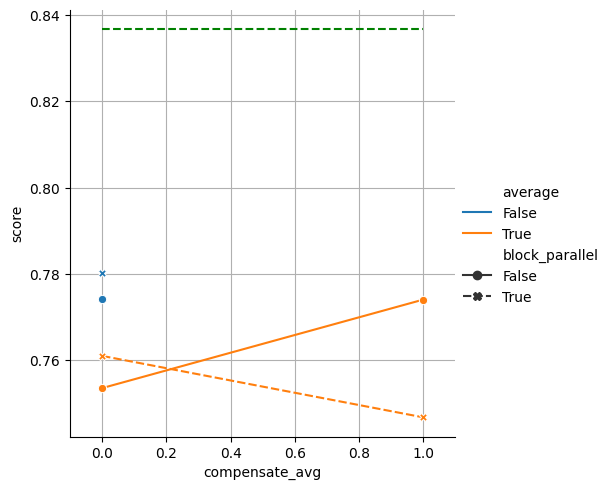

In [64]:
fig = plt.figure()
sns.relplot(
    data=results_df[(results_df['p_rate'] == 2) & (results_df['iterative'] == True)],
    # col='p_rate',
    y='score',
    hue='average',
    x='compensate_avg',
    # size=...,
    # hue='iterative',
    style='block_parallel',
    kind='line',
    markers=True
    # row=...
    # xlim=[-0.1, 1.0],
    # ylim=[0.0, 1.1]
)
plt.xlim([-0.1, 1.1])
# plt.ylim([0.0, 1.0])
plt.hlines(0.8366859191396137, 0, 1, colors='g', linestyles='dashed', label='base_model')
plt.grid()
# plt.legend(loc='center')
plt.show()

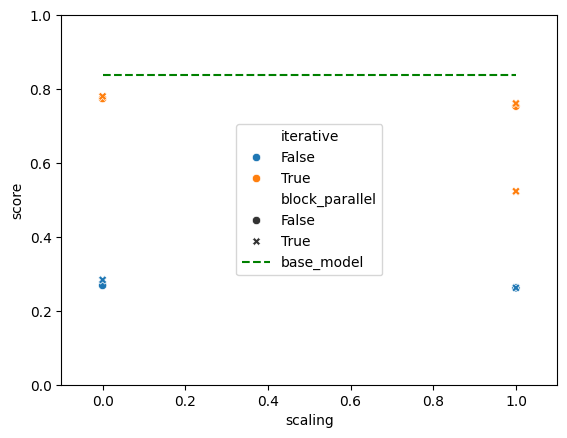

In [55]:
fig = plt.figure()
sns.scatterplot(  # TODO
    data=results_df,
    x='scaling', 
    y='score', 
    hue='iterative',
    style='block_parallel'
)
# plt.xscale('log')
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.0])
plt.hlines(0.8366859191396137, 0, 1, colors='g', linestyles='dashed', label='base_model')
plt.legend(loc='center')
plt.show()

In [ ]:
fig.savefig(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, f'results_attn.pdf'))